- The data loading, prepation, and predictions are the same as the notebook P2_1_CNNs_on_face_sentiment_classification.ipynb \
- This code focuses on the fine-tuning of Vision Transformer (ViT) \


In [1]:
#!pip install transformers

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
from transformers import AutoImageProcessor, TFViTModel

## Downloading data, lodading data into datasets

In [3]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/datasets/kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

human-emotions-datasethes.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Kaggle Human Emotion Dataset: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
# task: image multiclass classification

!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Archive:  /content/human-emotions-datasethes.zip
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # the makes the labels match the subdirectories
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    #validation_split=0.2,
    #subset="training", #or validation
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred', # the makes the labels match the subdirectories
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=1, #CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99
    #validation_split=0.2,
    #subset="training", #or validation
)

Found 2278 files belonging to 3 classes.


In [10]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 89.      ,  89.      ,  89.      ],
         [ 91.4375  ,  91.4375  ,  91.4375  ],
         [ 85.8125  ,  85.8125  ,  85.8125  ],
         ...,
         [ 26.6875  ,  26.6875  ,  26.6875  ],
         [ 26.      ,  26.      ,  26.      ],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 79.25    ,  79.25    ,  79.25    ],
         [ 86.30859 ,  86.30859 ,  86.30859 ],
         [ 87.89453 ,  87.89453 ,  87.89453 ],
         ...,
         [ 25.875   ,  25.875   ,  25.875   ],
         [ 25.339844,  25.339844,  25.339844],
         [ 26.      ,  26.      ,  26.      ]],

        [[ 71.5     ,  71.5     ,  71.5     ],
         [ 79.625   ,  79.625   ,  79.625   ],
         [ 87.60156 ,  87.60156 ,  87.60156 ],
         ...,
         [ 24.570312,  24.570312,  24.570312],
         [ 23.253906,  23.253906,  23.253906],
         [ 24.625   ,  24.625   ,  24.625   ]],

        ...,

        [[170.      , 170.      ,

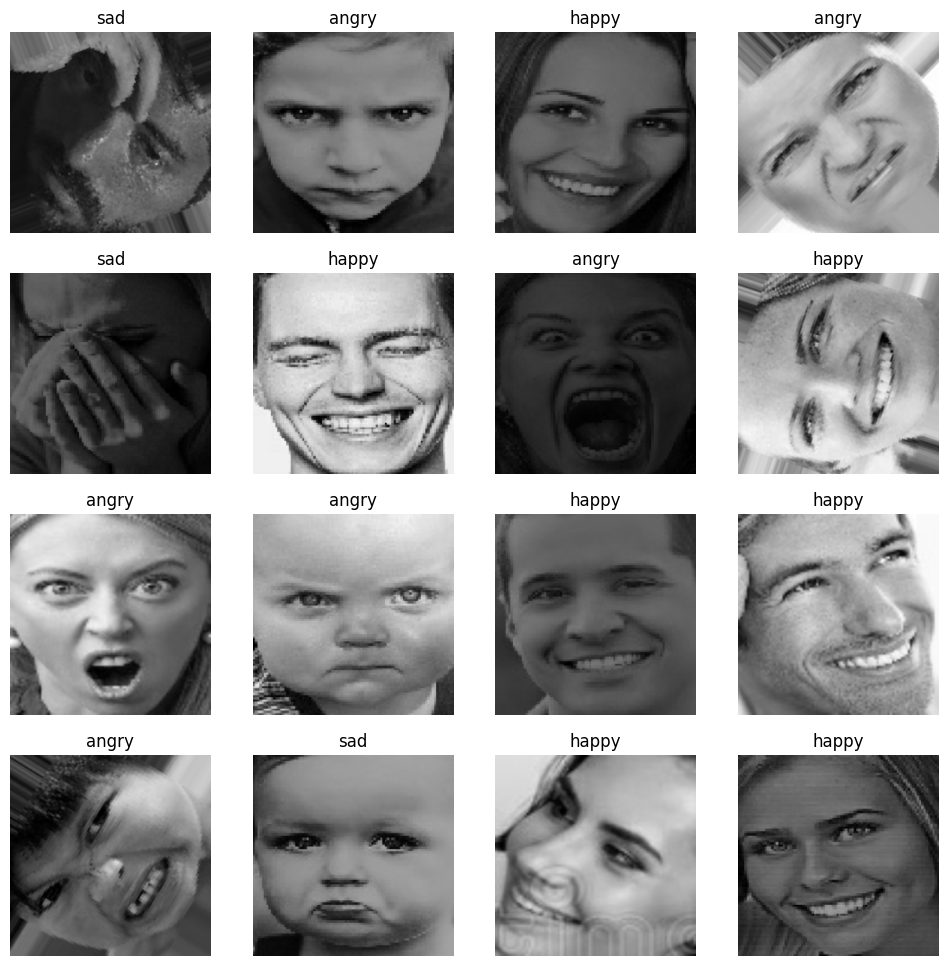

In [11]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")

In [12]:
# prefetch to make the processing faster

training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
# create resizing and rescaling layers; its part of the model

resize_rescale_layers_hf = tf.keras.Sequential([
    Resizing(224,224),
    Rescaling(1./255),
    Permute((3,1,2)) #batch, 224(1),224(2),3(3) > batch, 3(3),224(1),224(2) # the hf default shape is CLASS, IM_SIZE, IM_SIZE
])

## Fine-tuning ViT

In [15]:
# config

from transformers import ViTConfig, ViTModel

# Initializing a ViT vit-base-patch16-224 style configuration
configuration = ViTConfig(hidden_size = 144)

# Initializing a model (with random weights) from the vit-base-patch16-224 style configuration
model = ViTModel(configuration)

# Accessing the model configuration
configuration = model.config

In [16]:
print(configuration)

ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 144,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.30.2"
}



In [17]:
from transformers import AutoImageProcessor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))

x = resize_rescale_layers_hf(inputs)
x = base_model.vit(x)[0][:,0,:] #[0] > only the last hidden states like [1,197,768]; [0][:,0,:]> (1,768)

#add classification layer
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [18]:
hf_model = tf.keras.Model(inputs=inputs, outputs=output)

In [19]:
# test on one image
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

hf_model(tf.expand_dims(test_image, axis = 0)) #  in the result the hidden layer (within MLP) is 768

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.3923691 , 0.21125793, 0.39637297]], dtype=float32)>

In [20]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

## Set up Wandb for monitoring

In [21]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import wandb
from wandb.keras import WandbCallback

In [23]:
!wandb login

wandb: Currently logged in as: taolinmilestone. Use `wandb login --relogin` to force relogin


In [24]:
wandb.init(project="face_emotion_detection",config=CONFIGURATION) #initiate a run

wandb: Currently logged in as: taolinmilestone. Use `wandb login --relogin` to force relogin


## Training, loss function, evaluation, prediction, and confusion matrix

In [25]:
checkpoint_callback = ModelCheckpoint(
    '/content/best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,#save best weights
    )

## Customized functions for wandb

In [26]:
# https://wandb.ai/wandb/plots/reports/Confusion-Matrix-Usage-and-Examples--VmlldzozMDg1NTM

class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [34]:
#https://docs.wandb.ai/guides/track/log/log-tables

class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in validation_dataset.take(5):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label] #write values

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})

In [28]:
loss_function = CategoricalCrossentropy()

In [29]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")] #topk allows k nearest labels

In [35]:
# compile the model

hf_model.compile(
  optimizer = Adam(learning_rate = 5e-5),
  loss = loss_function,
  metrics = metrics,
)

In [36]:
history1 = hf_model.fit(
    training_dataset.take(20),
    validation_data = validation_dataset.take(5),
    epochs = 3,#60
    verbose = 1,
    callbacks=[WandbCallback(),LogConfMatrix(),LogResultsTable()]
    #callbacks=[checkpoint_callback] #local callback
)

Epoch 1/3


20/20 [==============================] - ETA: 0s - loss: 0.4102 - accuracy: 0.8589 - top_k_accuracy: 0.9674

wandb: Adding directory to artifact (/content/wandb/run-20230619_054011-tpxdz7iv/files/model-best)... Done. 28.1s


20/20 [==============================] - 692s 34s/step - loss: 0.4102 - accuracy: 0.8589 - top_k_accuracy: 0.9674 - val_loss: 0.0997 - val_accuracy: 1.0000 - val_top_k_accuracy: 1.0000
Epoch 2/3
20/20 [==============================] - 590s 31s/step - loss: 0.2233 - accuracy: 0.9391 - top_k_accuracy: 0.9922 - val_loss: 0.8391 - val_accuracy: 0.6000 - val_top_k_accuracy: 1.0000
Epoch 3/3
20/20 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9766 - top_k_accuracy: 0.9953

wandb: Adding directory to artifact (/content/wandb/run-20230619_054011-tpxdz7iv/files/model-best)... Done. 20.6s


20/20 [==============================] - 634s 33s/step - loss: 0.1263 - accuracy: 0.9766 - top_k_accuracy: 0.9953 - val_loss: 0.0277 - val_accuracy: 1.0000 - val_top_k_accuracy: 1.0000


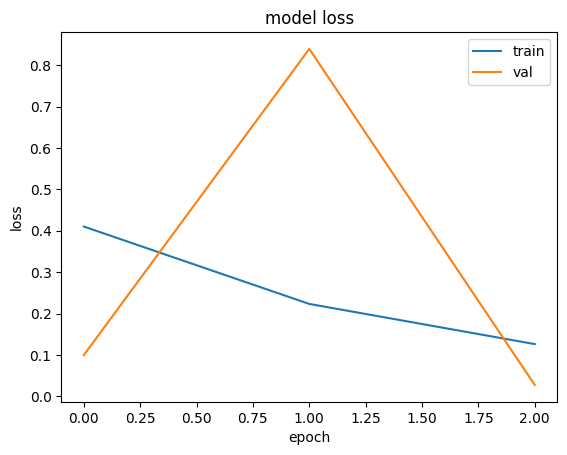

In [37]:
# plot loss history
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

In [38]:
#lenet_model.evaluate(validation_dataset)
hf_model.evaluate(validation_dataset)

2278/2278 [==============================] - 101s 44ms/step - loss: 0.5549 - accuracy: 0.8025 - top_k_accuracy: 0.9399


[0.5548883676528931, 0.8024582862854004, 0.9398595094680786]